# Sea Victims Detection - Inference

https://www.kaggle.com/code/ubiratanfilho/sea-victims-detection-inference

## Hyperparameters

In [1]:
resize = (256, 256)

## Dependencies

In [2]:
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 13.1 MB/s eta 0:00:00


In [3]:
import time
import os
import argparse

import pycocotools.coco as pyco

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models import resnet18, resnet50, resnet101,\
    ResNet101_Weights, ResNet18_Weights, ResNet50_Weights
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

## Dataset Class

In [4]:
class SDSDataset(Dataset):
    def __init__(self, root, annotation_file, resize):
        self.root = root
        self.coco = pyco.COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())
        self.num_classes = len(self.coco.cats)
        self.resize = resize
        self.transform = Compose([
            Resize(resize),
            ToTensor()
            ])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        coco = self.coco

        # Image ID of the input image
        img_id = self.ids[index]
        # Annotation IDs from coco
        ann_ids = coco.getAnnIds(img_id)
        # Load Annotation for the input image
        coco_annotation = coco.loadAnns(ann_ids)
        # Get path for the input image
        path = coco.loadImgs(img_id)[0]['file_name']

        # Open input image
        org_image = Image.open(os.path.join(self.root, path))

        # Get size of input image
        org_height = org_image.height
        org_width = org_image.width

        # Apply transformation (resize) to input image
        image = self.transform(org_image)

        # Get number of objects in the input image
        num_objects = len(coco_annotation)

        # Get bounding boxes and category labels
        # Coco format: bbox = [xmin, ymin, width, height]
        # Pytorch format: bbox = [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in range(num_objects):
            # Convert and resize boxes
            xmin = coco_annotation[i]['bbox'][0] / (org_width/self.resize[1])
            ymin = coco_annotation[i]['bbox'][1] / (org_height/self.resize[0])
            xmax = xmin + coco_annotation[i]['bbox'][2] / (org_width/self.resize[1])
            ymax = ymin + coco_annotation[i]['bbox'][3] / (org_height/self.resize[0])
            labels.append(coco_annotation[i]['category_id'])
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([img_id])

        # Get (rectangular) size of bbox
        areas = []
        for i in range(num_objects):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)

        # Get Iscrowd
        iscrowd = torch.zeros((num_objects,), dtype=torch.int64)

        # Create annotation dictionary
        annotation = dict()
        annotation['boxes'] = boxes
        annotation['labels'] = labels
        annotation['image_id'] = img_id
        annotation['area'] = areas
        annotation['iscrowd'] = iscrowd

        # Save width and height of the original image to rescale bounding boxes later on
        annotation['org_h'] = torch.as_tensor(org_height, dtype=torch.int64)
        annotation['org_w'] = torch.as_tensor(org_width, dtype=torch.int64)

        return image, annotation

## Reading Data

In [5]:
# Images
train_data_dir = '/kaggle/input/sds-dataset/compressed/images/train'
test_data_dir = '/kaggle/input/sds-dataset/compressed/images/val'
# Annotations
train_annotation_dir = '/kaggle/input/sds-dataset/compressed/annotations/instances_train.json'
test_annotation_dir = '/kaggle/input/sds-dataset/compressed/annotations/instances_val.json'

In [6]:
# Check if Cuda is available
print(f'Cuda available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    # If yes, use GPU
    device = torch.device('cuda')
else:
    # If no, use CPU
    device = torch.device('cpu')

Cuda available: True


In [7]:
# Create Datasets
train_dataset = SDSDataset(train_data_dir, train_annotation_dir, resize)
test_dataset = SDSDataset(test_data_dir, test_annotation_dir, resize)

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [8]:
# Create Dataloader
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader_train = DataLoader(train_dataset,
                               batch_size=32,
                               shuffle=True,
                               collate_fn=collate_fn)
data_loader_test = DataLoader(test_dataset,
                              batch_size=32,
                              shuffle=True,
                              collate_fn=collate_fn)

## Loading Model

In [9]:
modules = list(resnet18(weights=ResNet18_Weights.DEFAULT).children())[:-2]
backbone = nn.Sequential(*modules)
backbone.out_channels = 512

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 306MB/s]


In [10]:
# Create Anchor Generator
anchor_generator = AnchorGenerator(sizes=((8, 16, 32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

In [11]:
# Initialize FasterRCNN with Backbone and AnchorGenerator
model = FasterRCNN(backbone=backbone,
                   rpn_anchor_generator=anchor_generator,
                   num_classes=train_dataset.num_classes)

model.load_state_dict(torch.load('/kaggle/input/model-pytorch/model_20231007.pth'))

# Send model to device
model.to(device)

print('Model Loaded')

Model Loaded


## Inference

In [12]:
model.eval()
cntr = 0

with torch.no_grad():
    for images, targets in data_loader_test:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        pred_dict = model(images)
        break

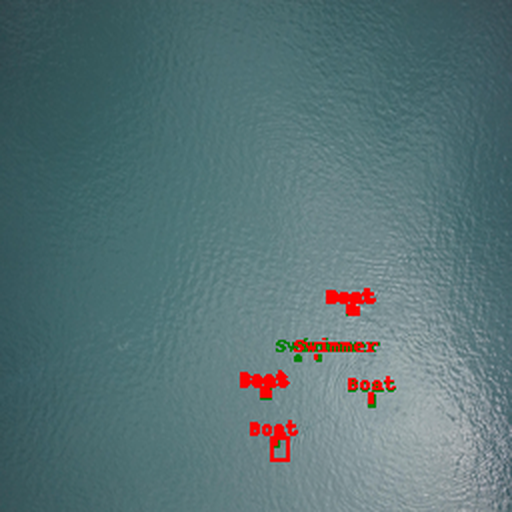

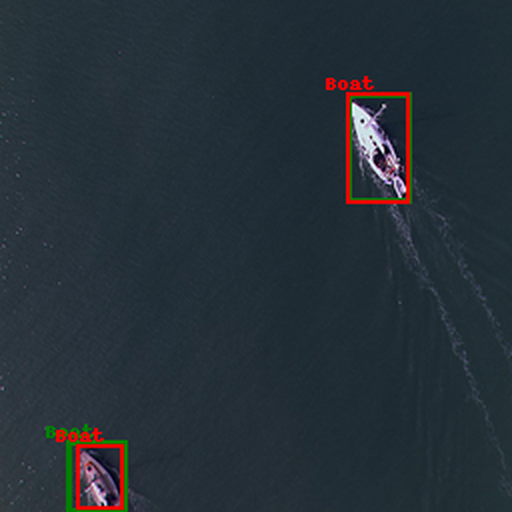

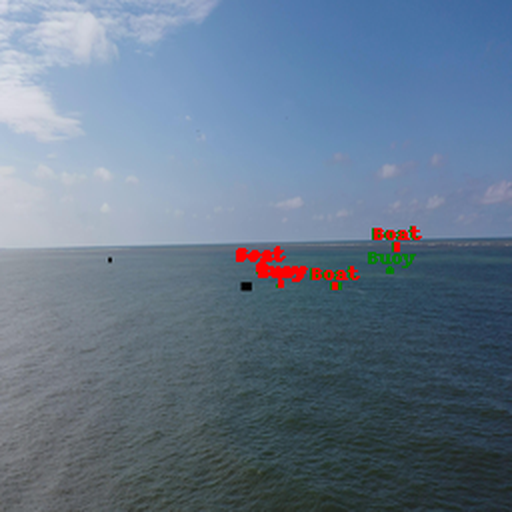

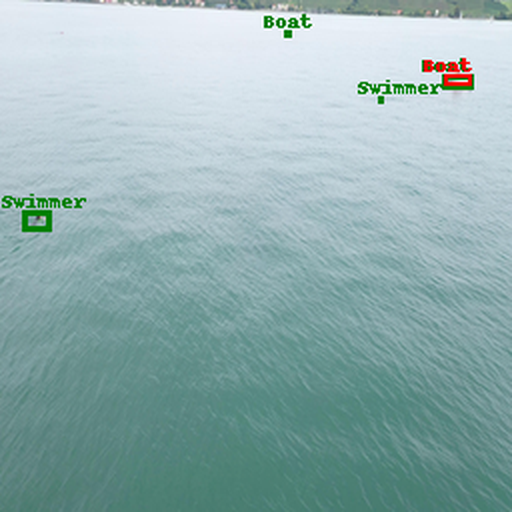

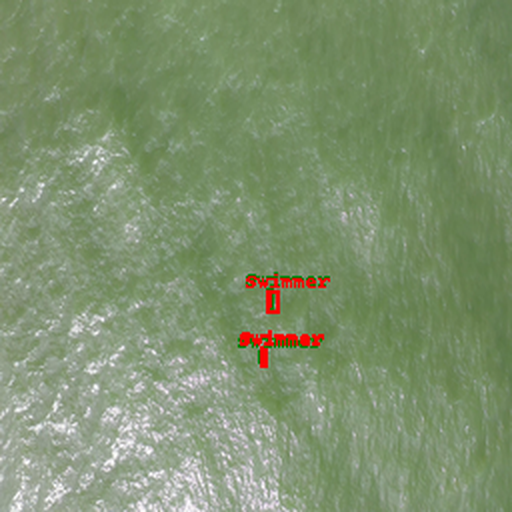

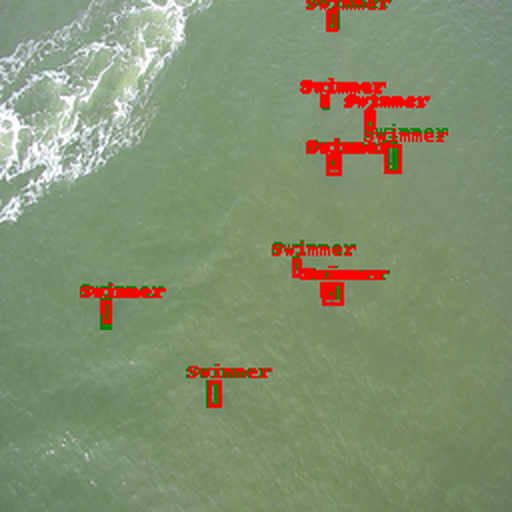

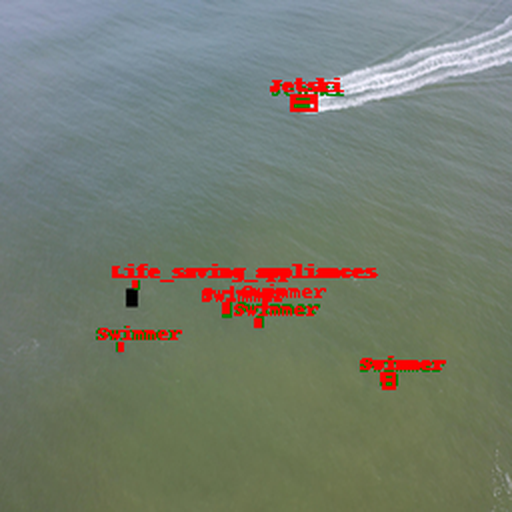

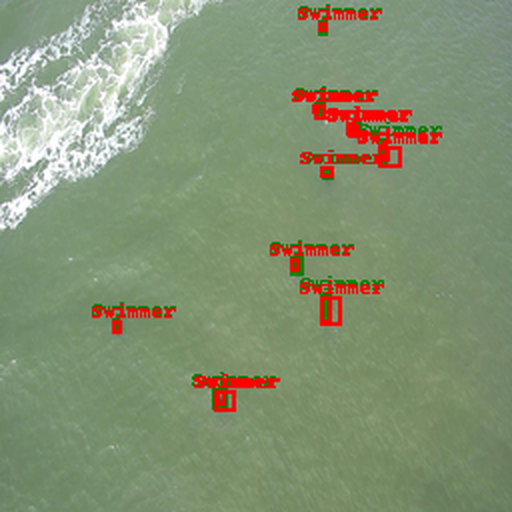

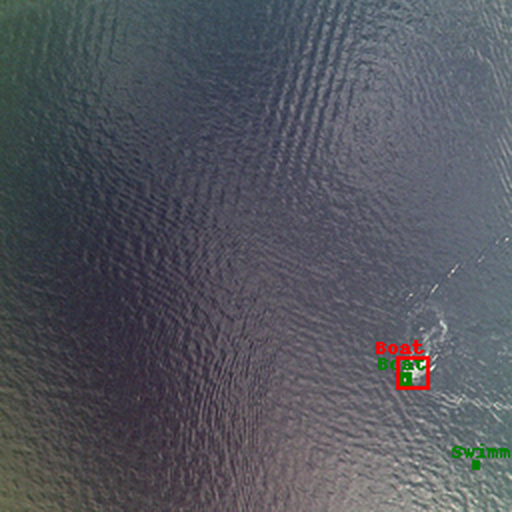

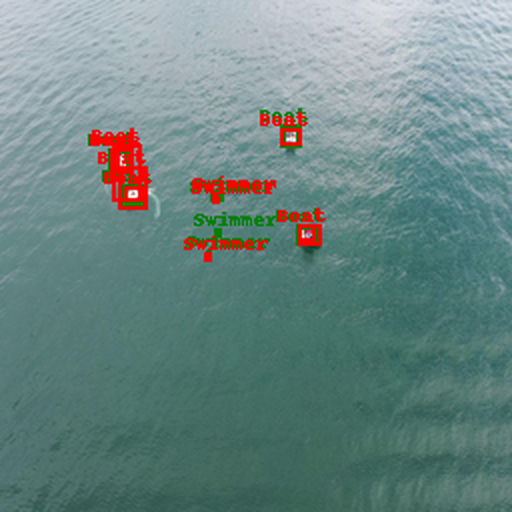

In [16]:
for i in range(10):
    # Get image id and original size
    img_id = targets[i]['image_id'].item()
    org_width = targets[i]['org_w'].item()
    org_height = targets[i]['org_h'].item()

    # Open image with id
    path = '/kaggle/input/sds-dataset/compressed/images/val/' + test_dataset.coco.loadImgs(img_id)[0]['file_name']
    image = Image.open(os.path.join(test_data_dir, path))
    image = image.resize((256, 256), Image.LANCZOS)

    draw = ImageDraw.Draw(image)
    # real bounding boxes
    for box, label in zip(targets[i]['boxes'], targets[i]['labels']):
                # Rescale bounding box coordinates
                xmin = box[0].item()
                ymin = box[1].item()
                xmax = box[2].item()
                ymax = box[3].item()

                cat = test_dataset.coco.loadCats(label.item())[0]['name']

                draw.rectangle(((xmin, ymin), (xmax, ymax)), width=3, outline='green')
                draw.text((xmin - 10, ymin - 10),
                          cat.capitalize(),
                          fill='green', align='left')

    # predictions
    # Draw predicted bounding boxes, labels and scores
    for box, label, score in zip(pred_dict[i]['boxes'],
                                 pred_dict[i]['labels'],
                                 pred_dict[i]['scores']):
        if score.item() < float(0.5):
            continue

    # Rescale bounding box coordinates
        xmin = box[0].item()
        ymin = box[1].item()
        xmax = box[2].item()
        ymax = box[3].item()

        cat = test_dataset.coco.loadCats(label.item())[0]['name']

        draw.rectangle(((xmin, ymin), (xmax, ymax)), width=2, outline='red')
        draw.text((xmin-10, ymin-10),
                  cat.capitalize(),
                  fill='red', align='right',
                  stroke_width=0.2)

    display(image.resize((512, 512), Image.LANCZOS))